,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


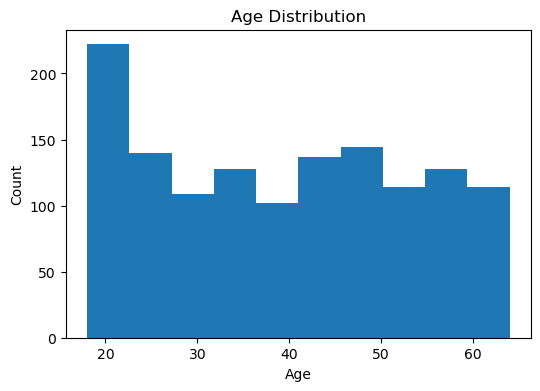

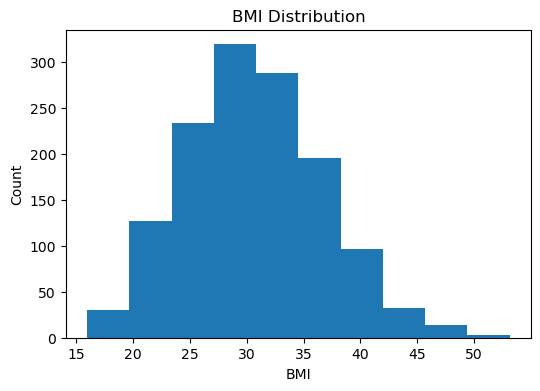

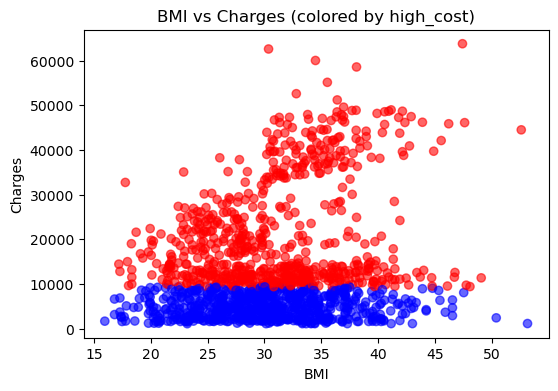

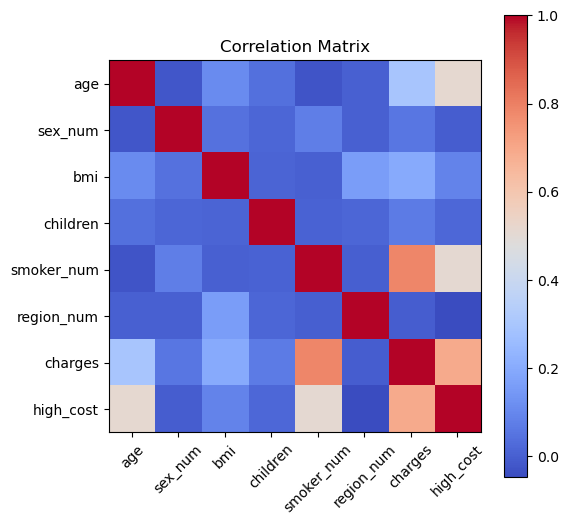

Scratch Model Accuracy: 70.48%
scikit-learn Model Accuracy: 91.42%
Confusion Matrix:
[[132  14]
 [  9 113]]

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.94      0.90      0.92       146
   High Cost       0.89      0.93      0.91       122

    accuracy                           0.91       268
   macro avg       0.91      0.92      0.91       268
weighted avg       0.92      0.91      0.91       268



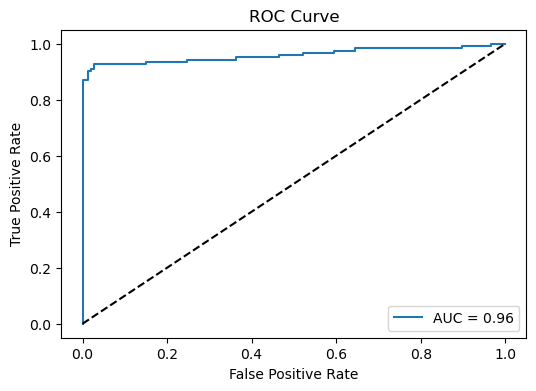

In [5]:
# Logistic Regression on Insurance Data (Jupyter-ready)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# 1. Load the data
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
display(df.head())

# 2. Create binary target: high_cost = 1 if charges > median, else 0
median_charge = df['charges'].median()
df['high_cost'] = (df['charges'] > median_charge).astype(int)

# 3. Encode categorical variables
df['smoker_num'] = df['smoker'].map({'yes':1, 'no':0})
df['sex_num']    = df['sex'].map   ({'male':1, 'female':0})
df['region_num'] = df['region'].astype('category').cat.codes

# 4. Quick visualizations
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=10)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['bmi'], bins=10)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['bmi'], df['charges'], c=df['high_cost'], cmap='bwr', alpha=0.6)
plt.title('BMI vs Charges (colored by high_cost)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

# 5. Correlation matrix
corr = df[['age','sex_num','bmi','children','smoker_num','region_num','charges','high_cost']].corr()
plt.figure(figsize=(6,6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.show()

# 6. Logistic Regression FROM SCRATCH using BMI and smoker status
X = df[['bmi', 'smoker_num']].values
Y = df['high_cost'].values
X = (X - X.mean(axis=0)) / X.std(axis=0)   # standardize

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# initialize parameters
w = np.zeros(X.shape[1])
b = 0.0
alpha = 0.1
iterations = 10000

for i in range(iterations):
    idx = np.random.randint(len(Y))
    x_i = X[idx]
    y_i = Y[idx]
    y_hat = sigmoid(np.dot(w, x_i) + b)
    dw = (y_hat - y_i) * x_i
    db = (y_hat - y_i)
    w -= alpha * dw
    b -= alpha * db

# evaluate scratch model
y_pred_scratch = (sigmoid(X.dot(w) + b) >= 0.5).astype(int)
scratch_acc = np.mean(y_pred_scratch == Y)
print(f"Scratch Model Accuracy: {scratch_acc:.2%}")

# 7. scikit-learn Logistic Regression using all features
X_full = df[['age','sex','bmi','children','smoker','region']].copy()
X_full = pd.get_dummies(X_full, drop_first=True)
y_full = df['high_cost']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

y_pred_full = clf.predict(X_test_scaled)
full_acc = clf.score(X_test_scaled, y_test)
print(f"scikit-learn Model Accuracy: {full_acc:.2%}")

# 8. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_full))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_full, target_names=['Low Cost','High Cost']))

# 9. ROC Curve
probs = clf.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
